In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.notebook import tqdm, trange
import numpy as np
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [3]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/Project/us-patent-phrase-to-phrase-matching'
train_path = data_dir + '/train_data_roberta_concat.csv'
val_path = data_dir + '/val_data_roberta_concat.csv'
test_path = data_dir + '/test_data_roberta_concat.csv'

Mounted at /content/drive


In [4]:
train_path

'/content/drive/MyDrive/Project/us-patent-phrase-to-phrase-matching/train_data_roberta_concat.csv'

In [5]:
class PatentDataset(Dataset):
    def process_data(self, data_df):
        score_to_class = {0: 0, 0.25: 1, 0.5: 2, 0.75: 3, 1: 4}
        data_df['class'] = data_df.apply(lambda x: score_to_class[x['score']], axis=1)

        y = data_df['class'].to_numpy()
        data_df = data_df.drop(columns=['score', 'class'])
        X = data_df.to_numpy()
        #print(list(data_df.columns))
        # anchor_cols = ['anchor_' + str(i) for i in range(768)]
        # target_cols = ['target_' + str(i) for i in range(768)]
        # anchor_data = data_df[anchor_cols].to_numpy()
        # #print('anchor_data', anchor_data)
        # #print('anchor_data', anchor_data.shape)
        # target_data = data_df[target_cols].to_numpy()
        # #print('target_data', target_data)
        # #print('target_data', target_data.shape)
        # aggr_data = np.multiply(anchor_data, target_data)
        # #print('aggr_data', aggr_data)
        # #print('aggr_data', aggr_data.shape)
        # data_df = data_df.drop(columns=anchor_cols)
        # data_df = data_df.drop(columns=target_cols)
        # #print('data_df', data_df.shape)
        # #print('data_df', list(data_df.columns))
        # context_data = data_df.to_numpy()
        # #print('context_data', context_data.shape)
        # X = np.concatenate((aggr_data, context_data), axis=1)
        # #print(X.shape, y.shape)
        return X, y
    def __init__(self, data_path):
        super(PatentDataset, self).__init__()

        data_df = pd.read_csv(data_path)
        X, y = self.process_data(data_df)

        self.X = torch.from_numpy(X).double()
        self.y = torch.from_numpy(y).long()
        print(self.X.dtype)
        print('X.shape', self.X.shape, 'y.shape', self.y.shape)
        self.len = X.shape[0]

    def __getitem__(self, index):
        if torch.is_tensor(index):
           index = index.tolist()
        return self.X[index], self.y[index] 

    def __len__(self):
        return self.len

In [6]:
train_set = PatentDataset(train_path)
val_set = PatentDataset(val_path)
test_set = PatentDataset(test_path)

torch.float64
X.shape torch.Size([26351, 768]) y.shape torch.Size([26351])
torch.float64
X.shape torch.Size([4651, 768]) y.shape torch.Size([4651])
torch.float64
X.shape torch.Size([5471, 768]) y.shape torch.Size([5471])


In [7]:
train_loader = DataLoader(dataset=train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset=test_set, batch_size=32, shuffle=False)

In [8]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(768, 1500)
        self.fc2 = nn.Linear(1500, 1500)
        self.fc3 = nn.Linear(1500, 500)
        self.fc4 = nn.Linear(500, 5)
        print(self.fc4.weight.dtype, self.fc4.bias.dtype)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [9]:
model = Model().double().to(device)
print(sum(p.numel() for p in model.parameters()))

torch.float32 torch.float32
4158005


In [10]:
def plot_loss(loss, title, xlabel, ylabel):
    epoch = list(range(len(loss)))
    plt.plot(epoch, loss)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
epoch_count = 100
epoch_train_loss = []
epoch_val_loss = []
patience = np.Inf
patience_lost = 0
for epoch in range(1, epoch_count+1):
    print('Epoch', epoch)
    model.train()
    batch_train_loss = []
    for (X, y) in tqdm(train_loader, desc='Training epoch ' + str(epoch), leave=False):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        batch_train_loss.append(loss.item())
    epoch_train_loss.append(np.mean(batch_train_loss))
    print('Train loss: %.3f' % epoch_train_loss[-1], flush=True, end='')

    batch_val_loss = []
    model.eval()
    with torch.no_grad():
        for (X, y) in tqdm(val_loader, desc='Validation epoch', leave=False):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = criterion(pred, y)
            batch_val_loss.append(loss.item())
    epoch_val_loss.append(np.mean(batch_val_loss))
    print('Val loss: %.3f' % epoch_val_loss[-1], flush=True)
    if(epoch > 1):
        if(epoch_val_loss[-1] >= epoch_val_loss[-2]):
            patience_lost += 1
            if(patience_lost == patience):
                break
        else:
            patience_lost = 0        

Epoch 1


Training epoch 1:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 1.399

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.380
Epoch 2


Training epoch 2:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 1.344

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.350
Epoch 3


Training epoch 3:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 1.296

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.315
Epoch 4


Training epoch 4:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 1.243

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.294
Epoch 5


Training epoch 5:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 1.195

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.272
Epoch 6


Training epoch 6:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 1.143

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.289
Epoch 7


Training epoch 7:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 1.094

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.287
Epoch 8


Training epoch 8:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 1.045

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.289
Epoch 9


Training epoch 9:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 1.001

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.307
Epoch 10


Training epoch 10:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.948

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.332
Epoch 11


Training epoch 11:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.901

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.361
Epoch 12


Training epoch 12:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.851

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.463
Epoch 13


Training epoch 13:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.807

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.431
Epoch 14


Training epoch 14:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.760

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.453
Epoch 15


Training epoch 15:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.723

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.539
Epoch 16


Training epoch 16:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.677

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.597
Epoch 17


Training epoch 17:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.640

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.674
Epoch 18


Training epoch 18:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.603

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.699
Epoch 19


Training epoch 19:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.573

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.702
Epoch 20


Training epoch 20:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.542

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.957
Epoch 21


Training epoch 21:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.520

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.854
Epoch 22


Training epoch 22:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.488

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.966
Epoch 23


Training epoch 23:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.457

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 1.983
Epoch 24


Training epoch 24:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.444

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.058
Epoch 25


Training epoch 25:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.422

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.135
Epoch 26


Training epoch 26:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.396

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.174
Epoch 27


Training epoch 27:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.388

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.244
Epoch 28


Training epoch 28:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.365

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.364
Epoch 29


Training epoch 29:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.356

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.439
Epoch 30


Training epoch 30:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.338

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.461
Epoch 31


Training epoch 31:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.333

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.401
Epoch 32


Training epoch 32:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.318

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.587
Epoch 33


Training epoch 33:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.296

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.698
Epoch 34


Training epoch 34:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.280

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.679
Epoch 35


Training epoch 35:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.301

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.626
Epoch 36


Training epoch 36:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.274

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.794
Epoch 37


Training epoch 37:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.267

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.694
Epoch 38


Training epoch 38:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.252

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.920
Epoch 39


Training epoch 39:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.261

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.970
Epoch 40


Training epoch 40:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.250

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.963
Epoch 41


Training epoch 41:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.247

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.738
Epoch 42


Training epoch 42:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.234

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 2.921
Epoch 43


Training epoch 43:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.229

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.154
Epoch 44


Training epoch 44:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.211

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.047
Epoch 45


Training epoch 45:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.215

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.125
Epoch 46


Training epoch 46:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.212

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.187
Epoch 47


Training epoch 47:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.210

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.294
Epoch 48


Training epoch 48:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.215

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.184
Epoch 49


Training epoch 49:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.195

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.348
Epoch 50


Training epoch 50:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.194

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.391
Epoch 51


Training epoch 51:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.200

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.278
Epoch 52


Training epoch 52:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.186

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.360
Epoch 53


Training epoch 53:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.187

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.384
Epoch 54


Training epoch 54:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.192

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.298
Epoch 55


Training epoch 55:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.191

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.195
Epoch 56


Training epoch 56:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.157

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.426
Epoch 57


Training epoch 57:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.178

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.310
Epoch 58


Training epoch 58:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.168

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.692
Epoch 59


Training epoch 59:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.177

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.357
Epoch 60


Training epoch 60:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.159

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.587
Epoch 61


Training epoch 61:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.154

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.492
Epoch 62


Training epoch 62:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.167

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.492
Epoch 63


Training epoch 63:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.182

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.387
Epoch 64


Training epoch 64:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.148

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.551
Epoch 65


Training epoch 65:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.141

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.675
Epoch 66


Training epoch 66:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.154

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.727
Epoch 67


Training epoch 67:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.165

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.661
Epoch 68


Training epoch 68:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.148

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.890
Epoch 69


Training epoch 69:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.159

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.702
Epoch 70


Training epoch 70:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.136

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.566
Epoch 71


Training epoch 71:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.145

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.922
Epoch 72


Training epoch 72:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.149

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.761
Epoch 73


Training epoch 73:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.132

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.843
Epoch 74


Training epoch 74:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.143

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.722
Epoch 75


Training epoch 75:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.150

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.745
Epoch 76


Training epoch 76:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.140

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 4.071
Epoch 77


Training epoch 77:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.126

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.876
Epoch 78


Training epoch 78:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.129

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.914
Epoch 79


Training epoch 79:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.116

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.988
Epoch 80


Training epoch 80:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.141

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.817
Epoch 81


Training epoch 81:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.141

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 4.014
Epoch 82


Training epoch 82:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.127

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.789
Epoch 83


Training epoch 83:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.128

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.935
Epoch 84


Training epoch 84:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.115

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 4.171
Epoch 85


Training epoch 85:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.147

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 4.151
Epoch 86


Training epoch 86:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.118

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 4.119
Epoch 87


Training epoch 87:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.123

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 3.861
Epoch 88


Training epoch 88:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.121

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 4.272
Epoch 89


Training epoch 89:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.115

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 4.407
Epoch 90


Training epoch 90:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.114

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 4.440
Epoch 91


Training epoch 91:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.129

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 4.113
Epoch 92


Training epoch 92:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.111

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 4.499
Epoch 93


Training epoch 93:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.147

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 4.424
Epoch 94


Training epoch 94:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.114

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 4.355
Epoch 95


Training epoch 95:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.127

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 4.134
Epoch 96


Training epoch 96:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.092

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 4.341
Epoch 97


Training epoch 97:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.120

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 4.130
Epoch 98


Training epoch 98:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.125

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 4.689
Epoch 99


Training epoch 99:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.109

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 4.589
Epoch 100


Training epoch 100:   0%|          | 0/824 [00:00<?, ?it/s]

Train loss: 0.113

Validation epoch:   0%|          | 0/146 [00:00<?, ?it/s]

Val loss: 4.487


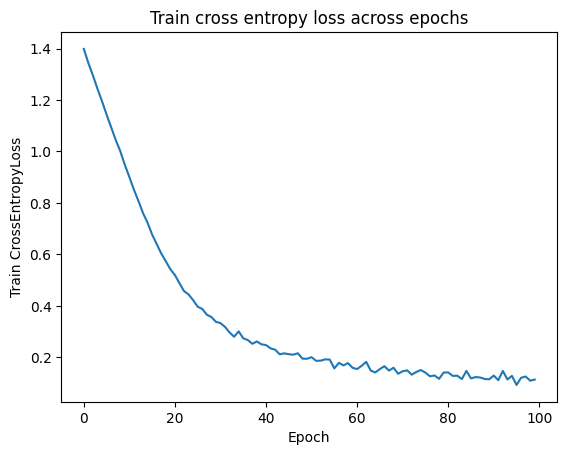

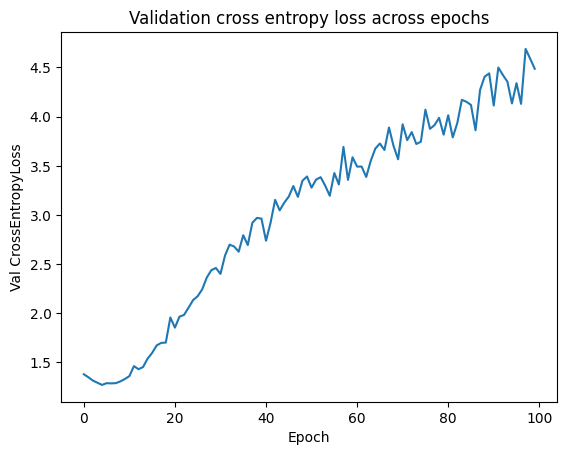

In [13]:
plot_loss(epoch_train_loss, 'Train cross entropy loss across epochs', 'Epoch', 'Train CrossEntropyLoss')
plot_loss(epoch_val_loss, 'Validation cross entropy loss across epochs', 'Epoch', 'Val CrossEntropyLoss')

In [14]:
from scipy.special import softmax
from sklearn.metrics import classification_report

def calc_metrics(dataset, model):
    y_true = None
    y_pred = None
    with torch.no_grad():
        X, y = dataset.X.to(device), dataset.y.to(device)
        pred = model(X)
        y_true = y.cpu().detach().numpy()
        y_pred = pred.cpu().detach().numpy()
    y_pred = softmax(y_pred, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    report = classification_report(y_true, y_pred)
    print(report)

In [15]:
print('Train evaluation')
calc_metrics(train_set, model)
print('Validation evaluation')
calc_metrics(val_set, model)
print('Test evaluation')
calc_metrics(test_set, model)

Train evaluation
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      5342
           1       0.97      0.98      0.97      8324
           2       0.96      0.97      0.97      8912
           3       0.96      0.93      0.95      2912
           4       0.90      0.92      0.91       861

    accuracy                           0.97     26351
   macro avg       0.96      0.95      0.95     26351
weighted avg       0.97      0.97      0.97     26351

Validation evaluation
              precision    recall  f1-score   support

           0       0.55      0.38      0.45      1005
           1       0.55      0.58      0.56      1453
           2       0.50      0.59      0.54      1559
           3       0.32      0.29      0.30       498
           4       0.21      0.26      0.23       136

    accuracy                           0.50      4651
   macro avg       0.43      0.42      0.42      4651
weighted avg       0.50      0.50     